## Train / Test Predictive Analytics

This section introduces the predictive analytics technique of splitting data into random subsets for **training and testing** a predictive model. In order to perform unbiased assessment of the classification model. This is illustrated for ROC analysis where the sensitivities and specificities of the training model are estimated from the held out testing data. 

### Training/Testing for unbiased sensitivity/specificity analysis

Thus far, we have considered examples in which the sensitivy, specificity and ROC curves are calculated on the same data as used for model development. In other words, they are applied to the same data as used for training. This tends to produce optimistic estimates of the error probabilities and adjustment is needed. The situation is analogous to the degree of freedom adjustments in computing the error variance in linear regression.

A general approach to this problem is to randomly subdivide the available data into two subsets: 


+ **Training data:** These data will be used for model building only and not for predictive assessment.


+ **Test data:** These data will not be used for model building; they will only be used for predictive assessment.


This general approach requires that we have enough data that the subsets are large enough to provide adequate power. The general approach will be applied to logistic regression classification here, and applied later to other predictive analytics approaches.

**Python libraries:**

    statsmodels.api, statsmodels.formula.api, scikit-learn

If you need to install these on your computer enter the following commands from a terminal or anaconda window:

    conda install scikit-learn
    conda install -c conda-forge statsmodels
 


### Example: binary response data split into train and test subsets

To illustrate the methods in a known context, we generate binary data from a logistic regression model. We import the functions needed to generate the simulated data.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm

In [2]:
# set the coefficient values
b0, b1 = -0.7, 2.1 
# 
# set sample size
n = 400   
#
# generate exogenous variable
X = norm.rvs(size=n, random_state=1)   
odds = np.exp(b0 + b1*X)   # odds depend on x
#
# convert odds to probabilities and generate response y
y = bernoulli.rvs(p=odds/(1+odds), size=n, random_state=12347)
dat = pd.DataFrame({'X':X, 'y':y})
dat.head(10)

,X,y
0,1.624345,1
1,-0.611756,0
2,-0.528172,0
3,-1.072969,0
4,0.865408,1
5,-2.301539,0
6,1.744812,1
7,-0.761207,0
8,0.319039,0
9,-0.249370,0


#### Random split into train and test sets

Next we split the data into train and test data sets for modeling and evaluation. To do this we import several modules from sklearn.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Here we specify that the training data should be 80% of the data, with 20% held out as testing data.

In [4]:
dat_train, dat_test = \
train_test_split(dat, test_size=0.20, random_state=123457)

Compare the shapes of the original, training and testing data frames:

In [5]:
dat.shape, dat_train.shape, dat_test.shape

((400, 2), (320, 2), (80, 2))

Here are the first few rows of the training data. Note that the data splitting is random, not systematic, so as to avoid any biases.

In [6]:
dat_train.head()

,X,y
303,-0.880578,0
273,0.884909,1
119,0.408901,1
60,-0.754398,0
121,-0.775162,0


#### Train the model

In this simple setting, training the model simply means fitting the logistic regression model to **training data** only. 

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [8]:
mod_train = smf.logit('y ~ X', data=dat_train).fit()
mod_train.summary()

Optimization terminated successfully.
         Current function value: 0.417736
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  320
Model:                          Logit   Df Residuals:                      318
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:                  0.3793
Time:                        11:28:39   Log-Likelihood:                -133.68
converged:                       True   LL-Null:                       -215.36
                                        LLR p-value:                 2.070e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8534      0.167     -5.121      0.000      -1.180      -0.527
X              2.4172      0.273      8.840      0.000       1.881       2.953
==============================================================================
"""

#### Test the model

To evaluate the accuracy of the model as a classifier, we use the **training data model** to compute predictive probabilities for the **test data**. Then we will compare the thresholded classifications based on test data $X$ variable only, to the actual responses $y$ in the test data. Here are the first 10 predictive probabilities.

In [9]:
phat = mod_train.predict(exog=dict(X=dat_test['X'])) 
phat.head(10)

323    0.054672
222    0.948561
11     0.002920
346    0.220987
223    0.356884
139    0.322830
376    0.986799
12     0.163461
55     0.637519
171    0.790127
dtype: float64

To help visualize training versus testing, we plot the actual responses $y$ in the test set versus their predicted or estimated probabiliites based on the training model and their correpsonding $X$ values.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

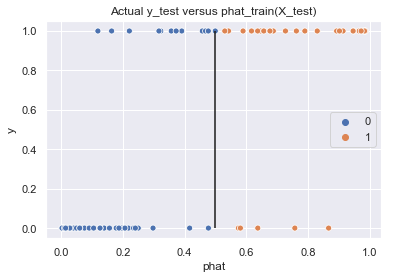

In [11]:
thresh = 0.5
sns.scatterplot(x=phat, y=dat_test['y'], hue=1*(phat > thresh))
plt.legend(loc='center right')
plt.xlabel('phat')
plt.vlines(x=thresh, ymin=0, ymax=1)
plt.title('Actual y_test versus phat_train(X_test)')
plt
plt.show()

**Function to compute sensitivity and specificity for a given threshold.**

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [13]:
def senspec(y, score, thresh):
    yhat = 1*(score >= thresh)
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=yhat).ravel()
    sens = tp / (fn + tp)
    spec = tn / (fp + tn)
    return pd.DataFrame({'tn':[tn], 
                         'fp':[fp], 
                         'fn':[fn], 
                         'tp':[tp], 
                         'sens':[sens], 
                         'spec':[spec]})

**Test results based on current threshold:**

In [14]:
senspec(dat_test['y'], phat, thresh)

,tn,fp,fn,tp,sens,spec
0,38,5,12,25,0.675676,0.883721


**Comparison with naive training data results**

In [15]:
senspec(dat_train['y'], mod_train.fittedvalues, thresh)

,tn,fp,fn,tp,sens,spec
0,175,17,46,82,0.640625,0.911458


**Test results with different threshold:**

In [16]:
senspec(dat_test['y'], phat, 0.33)

,tn,fp,fn,tp,sens,spec
0,36,7,5,32,0.864865,0.837209


In this example using 0.33 gives considerably higher sensitivity at a small cost in specificity.

#### ROC curve for test data

In [17]:
fpr, tpr, score = roc_curve(y_true=dat_test['y'], y_score=phat)
auc = roc_auc_score(y_true=dat_test['y'], y_score=phat)

In [18]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
             label='ROC curve (area = '+str(round(auc,3))+')')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

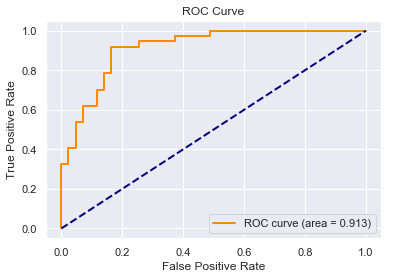

In [19]:
plot_roc(fpr, tpr, auc)

The AUC performance (0.913) is high. If we were to select a threshold minimizing distance to tehupper left corner, the ROC curve suggests that it may be possible to achieve a sensitivity (= true positive rate) of around 0.92 and specifity (= 1 - false positive rate) of around 0.84.

In [20]:
senspec(dat_test['y'], phat, 0.30)

,tn,fp,fn,tp,sens,spec
0,36,7,3,34,0.918919,0.837209


### Example: Train/Test ROC analysis for Pew Research Data

#### Preprocessing:

In [21]:
import zipfile as zp

In [22]:
zf = zp.ZipFile('../data/Feb17-public.zip')
missing_values = ["NaN", "nan", "Don't know/Refused (VOL.)"]
df = pd.read_csv(zf.open('Feb17public.csv'),
                 na_values=missing_values)[['age', 'sex', \
                                            'q52', 'party']]

In [23]:
# reduce q52 responses to two categories and 
# create binary reponse variable
df['q52'][df['q52']!='Favor'] = 'Not_favor'
df['y'] = df['q52'].map({'Not_favor':0,'Favor':1})
#
# use cleaned data without records that have missing values
dfclean = df.dropna()
dfclean.head()

,age,sex,q52,party,y
0,80.0,Female,Not_favor,Independent,0
1,70.0,Female,Not_favor,Democrat,0
2,69.0,Female,Not_favor,Independent,0
3,50.0,Male,Favor,Republican,1
4,70.0,Female,Not_favor,Democrat,0


**1. Split the data into train and test data sets.**

In [24]:
df_train, df_test = train_test_split(dfclean, 
                                   test_size=0.20, 
                                   random_state=1)

In [25]:
display("Training data", df_train.shape, df_train.head(),\
        "Testing data", df_test.shape, df_test.head())

'Training data'

(1172, 5)

,age,sex,q52,party,y
49,86.0,Male,Favor,Independent,1
1075,69.0,Female,Not_favor,Democrat,0
102,63.0,Male,Favor,Republican,1
1296,19.0,Male,Not_favor,Independent,0
338,60.0,Male,Not_favor,Democrat,0


'Testing data'

(293, 5)

,age,sex,q52,party,y
1032,50.0,Male,Not_favor,Democrat,0
671,40.0,Female,Not_favor,Republican,0
639,27.0,Male,Not_favor,Independent,0
943,43.0,Male,Not_favor,Independent,0
882,20.0,Male,Favor,No preference (VOL.),1


**2. Fit the model to training data only.**

In [26]:
pewmod = smf.logit('y ~ party + age + sex',\
    data=df_train).fit()
pewmod.summary()

Optimization terminated successfully.
         Current function value: 0.454704
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1172
Model:                          Logit   Df Residuals:                     1165
Method:                           MLE   Df Model:                            6
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:                  0.2818
Time:                        11:28:41   Log-Likelihood:                -532.91
converged:                       True   LL-Null:                       -742.00
                                        LLR p-value:                 3.438e-87
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.7460      0.324    -11.564      0.000      -4.381      -3.111
party[T.Independent]              1.8242      0.223      8.173      0.000       1.387       2.262
party[T.No preference (VOL.)]     1.8553      0.415      4.475      0.000       1.043       2.668
party[T.Other party (VOL.)]       2.1395      1.249      1.713      0.087      -0.308       4.587
party[T.Republican]               3.7061      0.239     15.537      0.000       3.239       4.174
sex[T.Male]                       0.4678      0.155      3.015      0.003       0.164       0.772
age                               0.0170      0.004      3.860      0.000       0.008       0.026
=================================================================================================
"""

**3. Get the predictive probabilities for the test data.**

The predict function uses the fitted model to extract any exogenous variables it needs from the test data. We do not have to specify which variables. We just provide the whole test data frame. Compare the following two code cells and results.

In [27]:
# predictive probabilities - explicit method
phat_test = pewmod.predict(exog=df_test[['age', 'sex', 'party']])
phat_test.head(10)

1032    0.080907
671     0.654430
639     0.269731
943     0.326381
882     0.252808
1228    0.079654
1179    0.288219
591     0.077712
550     0.413034
443     0.654430
dtype: float64

In [28]:
# predictive probabilities - implicit method
phat_test = pewmod.predict(exog=df_test)
phat_test.head(10)

1032    0.080907
671     0.654430
639     0.269731
943     0.326381
882     0.252808
1228    0.079654
1179    0.288219
591     0.077712
550     0.413034
443     0.654430
dtype: float64

**4a. Evaluation: Test data sensitivity and specificity**

In [29]:
# Using a probability threshold of 0.5
senspec(df_test['y'], phat_test, 0.5)

,tn,fp,fn,tp,sens,spec
0,162,16,50,65,0.565217,0.910112


In [30]:
# Using a probability threshold of 0.33
senspec(df_test['y'], phat_test, 0.3)

,tn,fp,fn,tp,sens,spec
0,128,50,29,86,0.747826,0.719101


**4b. Evaluation: Test data ROC curve**

In [31]:
fpr_pew, tpr_pew, score_pew = roc_curve(y_true=df_test['y'], y_score=phat_test)
auc_pew = roc_auc_score(y_true=df_test['y'], y_score=phat_test)

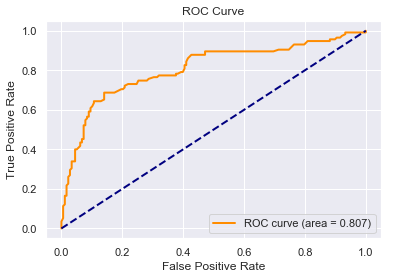

In [32]:
plot_roc(fpr_pew, tpr_pew, auc_pew)

For comparison, here is the naive ROC curve for the training data

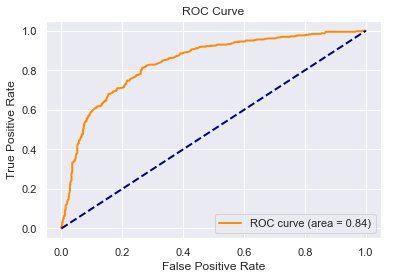

In [33]:
fpr_pew0, tpr_pew0, score_pew0 = roc_curve(y_true=df_train['y'], y_score=pewmod.fittedvalues)
auc_pew0 = roc_auc_score(y_true=df_train['y'], y_score=pewmod.fittedvalues)
plot_roc(fpr_pew0, tpr_pew0, auc_pew0)

In this example the training data AUC = 0.84, which is optimistic compared with unbiased test data AUC of 0.81.

---
STAT 207, Douglas Simpson, University of Illinois at Urbana-Champaign